In [1]:
import numpy as np
import soundfile as sf

def loadToMono(path):
    data, samplerate = sf.read(path)

    data_mono = []
    for i in range(len(data)):
        data_mono.append((data[i][0] + data[i][1]) / 2)
    
    return np.asarray(data_mono), samplerate

dataA, samplerate = loadToMono('/home/luca/Downloads/UprightPianoKW-SFZ-20190703/samples/A4vL.wav')
dataC, samplerate = loadToMono('/home/luca/Downloads/UprightPianoKW-SFZ-20190703/samples/C5vL.wav')
dataA3, samplerate = loadToMono('/home/luca/Downloads/UprightPianoKW-SFZ-20190703/samples/A3vL.wav')

def add(waves):
    assert(len(waves) >= 2)
    
    a = waves[0]
    b = waves[1]
    mx = a if a.size > b.size else b
    mn = a if a.size < b.size else b
    z = np.zeros(mx.shape)
    z[:mn.size] = mn
    combined = mx + z
    
    if len(waves) > 2:
        return add([combined] + waves[2:])
    elif len(waves) == 2:
        return combined

data_mono = add([dataA, dataA3])
data_mono

array([ 0.00000000e+00,  7.86185265e-05,  1.75297260e-04, ...,
       -1.04109049e-02, -1.09789968e-02, -1.14910603e-02])

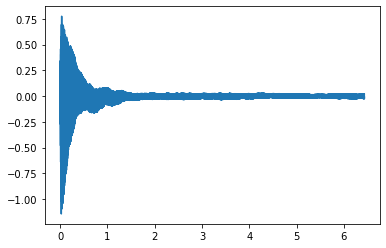

In [2]:
from matplotlib import pyplot

t = [(i) * 1/samplerate for i in range(data_mono.size)]

pyplot.plot(t, data_mono)
pyplot.show()

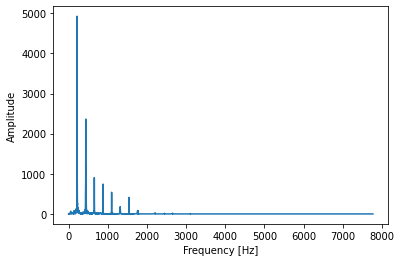

In [3]:
import matplotlib.pyplot as plt
s = np.asarray(data_mono)
fft = np.fft.fft(s)
T = 1/samplerate  # sampling interval 
N = s.size

# 1/T = frequency
f = np.linspace(0, 1 / T, N)

plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
x = f[:N // 2]
y = np.abs(fft)[:N // 2]

I = 50000

plt.plot(x[:I], y[:I])  # 1 / N is a normalization factor
plt.show()

In [4]:
def findAllAbove(freq, amp, a, discreteTolerance):
    c = amp >= a
    
    maxs = []
    curMax = []
    toleranceCounter = 0
    firstSignal = False

    for i in range(len(y)):
        if c[i]: 
            curMax.append((freq[i], amp[i]))
            firstSignal = True
        else:
            if len(curMax) == 0:
                continue
            else:
                if toleranceCounter > discreteTolerance:
                    m = np.max([x[1] for x in curMax])
                    f = freq[np.where(amp == m)][0]
                    maxs.append((f, m))
                    
                    curMax = []
                    toleranceCounter = 0
                    firstSignal = False
                else:
                    if firstSignal:
                        toleranceCounter += 1
    
    return maxs


maxs = findAllAbove(x, y, 200, 10)
maxs

[(219.34111409949557, 4925.404299309),
 (439.6149331490953, 2362.6000161957404),
 (658.1787931235041, 904.6582508349723),
 (880.0071204232775, 744.0027494404252),
 (1100.1254886478598, 539.3564215996212),
 (1545.1812006725627, 412.8219074575589)]

In [5]:
def filterMultiples(maxs, tol):
    copy = [m for m in maxs]
    mults = []
    cur = []
    
    while len(copy) > 0:
        cur.append(copy[0])
        del copy[0]
        
        removed = 0
        for i in range(len(copy)):
            ratio = copy[i - removed][0] / cur[0][0]
            if abs(ratio - round(ratio)) < tol:
                cur.append(copy[i - removed])
                del copy[i - removed]
                removed += 1
                
        mults.append(cur)
        cur = []
    
    return mults
        
    
filterMultiples(maxs, 0.1)

[[(219.34111409949557, 4925.404299309),
  (439.6149331490953, 2362.6000161957404),
  (658.1787931235041, 904.6582508349723),
  (880.0071204232775, 744.0027494404252),
  (1100.1254886478598, 539.3564215996212),
  (1545.1812006725627, 412.8219074575589)]]